**Consumer Theory for Cheap Information (Discrete case)**

This simulation illustrates some of the main results of "Consumer theory for cheap information." This code simulates the standard case where information is only consumed in discrete samples. See the other file for the case of infinitely divisible samples considered in the main text of the paper.

# Code setup

First, we need to import a number of standard Python packages:

In [91]:
import numpy as np                   # Basic array stuff
import scipy.optimize as optim       # For finding function mins
from scipy.stats import multinomial  # Multinomial probability computation
import matplotlib.pyplot as plt      # Plotting
from matplotlib import rc
from tabulate import tabulate        # For nicer printing of some data
import math
import time
from tqdm import tqdm   # Basic progress bar

# Model

A decision maker must take one of finitely many actions $a\in A$ facing an uncertain state of the world, $\theta$, that is one of finitely many possible states. She has a state-dependent payoff function, $u(a,\theta)$ and chooses her action to maximize expected payoff. Her prior is given by $p\in\Delta\Theta$.

Prior to acting, she may purchase information about the state and update her prior based on that information. As standard, define an information as a *Blackwell experiment*, that is, a collection of state-dependent distributions, $F(x\ |\ \theta)$ over some realization space, X:

$$ 
\mathcal{E} \equiv 
\{X, \langle F(\cdot\ |\ \theta)\rangle_{\theta\in\Theta}\} 
$$

(In a fully formal treatment, the definition would also include a σ-algebra. For the purposes of this paper, we can ignore such measure-theoretic complications). 

After observing a realization from an information source, the decision maker can update with Bayes rule:

$$ 
p'_\theta(x) = \frac{p_\theta f(x\ | \ \theta)}
           {\sum_{\theta'\in\Theta}p_{\theta'}f(x\ |\ \theta')}
$$

To avoid trivialities, assume that no realization perfectly rules in or out any subset of the states, that is, if realization has positive probability (density) under one state, it must have positive probability under all states. (In technical terms, assume the $F(\cdot\ |\ \theta)$ are all mutually absolutely continuous so the Radon-Nikodym derivatives, $dF(\cdot\ |\ \theta')/dF(\cdot\ |\ \theta)$ all exist.) For notational simplicity in this illustration, I'll assume each state-dependent distribution has finitely many possible realizations and thus pmf given by, $f$. 

We can the define an *amount* of information by a number of conditionally independent samples from such a source. 

For illustration, consider a two-state world, $\theta\in\{H,L\}$. An information source might be a coin that is fairly waited in the $L$ state, and biased 70% to heads in the $H$ state. Then samples from this source would simply be the number of coin flips. In an experimental setting, samples would be literal samples under some experimental design.

The DM has a collection of information sources $\mathcal{E}_i,\ldots, \mathcal{E}_I$ from each of which she can purchase an arbitrary number of samples, $\mathbf{n}=[n_i]$, at some cost $[c_i]$ each.

The goal is to characterize the substitutability of different information sources under the normal Bayesian (ex ante) information value---that is, the expected payoff gain from acting after observing a realization from information source $\mathcal{E}$:

$$
V(\mathcal{E}) \equiv 
\sum_{x\in R} \max_a 
\bigg\{\sum_\theta p'_\theta(x) u(a,\theta)\bigg\} 
f(x) 
-
\max_a 
\bigg\{\sum_\theta p_\theta u(a,\theta)\bigg\}
$$
where $f(x)\equiv \sum_\theta p_\theta f(x\ |\ \theta)$ is the unconditional realization probability for the given source. (NB: the paper works with expected *loss* rather than expected value. This doesn't affect the ordinal ranking of experiments, and thus has no effect on the budget-constrained model).

Information value is typically a very poorly behaved function, so I approach the problem with an asymptotic approach using large deviations methods.


Throughout this notebook, I'll be working with a 3 state decision problem.

In [92]:
numstates = 3

# Composite information sources and information values

## Defining information sources

In order to simulate information values, we need a way to define Blackwell experiments in a way amenable to computation: Define an information source as a $|\Theta|\times|X|$ matrix, so each row of the matrix lists the probability of each realization in that state. I will typically use Q to denote such a matrix.

The following code specifies a pair of information sources in this manner. By default, it will use a pair of experiments that produces relatively nice plots (including Fig. 3 in the paper). If those lines are removed/commented, the code will generate a random pair of information sources.

In [93]:
Qperfect = np.eye(numstates)   # Perfect information source

## Generate random experiments for testing
def rand_source(numstates, numrealizations):
    # generate a random array with the appropriate dimension
    Q = np.random.rand(numstates, numrealizations)
    # normalize so each row sums to 1
    for state in range(numstates):
        Q[state, :] = Q[state, :] / np.sum(Q[state, :])
    return Q

# Q1 = rand_source(numstates, 3)
# Q2 = rand_source(numstates, 3)

## The following are Blackwell ordered but have interior solutions
# Q1 = np.array([[0.50, 0.50],
#                [0.60, 0.40],
#                [0.65, 0.35]])
# Q2 = np.array([[0.10, 0.35, 0.55],
#                [0.35, 0.30, 0.35],
#                [0.10, 0.05, 0.85]])

Q1 = np.array([[0.07, 0.18, 0.75],
               [0.45, 0.19, 0.36],
               [0.45, 0.05, 0.50]])
Q2 = np.array([[0.42, 0.58],
               [0.63, 0.37],
               [0.03, 0.97]])

# state labels. Will use for nice output tables
states = []
for stateidx in range(Q1.shape[0]):
    states.append(["State {i}".format(i=stateidx)])

print("Conditional probability of each realization:\n")

# Output table and print
table1 = np.append(states, Q1, axis=1)
realizations1 = ["Q1"]
for realization in range(Q1.shape[1]):
    realizations1.append("X1 =" + " " + str(realization))
print(tabulate(table1, headers=realizations1)+"\n")

table2 = np.append(states, Q2, axis=1)
realizations2 = ["Q2"]
for realization in range(Q2.shape[1]):
    realizations2.append("X2 =" + " " + str(realization))
print(tabulate(table2, headers=realizations2))

Conditional probability of each realization:

Q1         X1 = 0    X1 = 1    X1 = 2
-------  --------  --------  --------
State 0      0.07      0.18      0.75
State 1      0.45      0.19      0.36
State 2      0.45      0.05      0.5

Q2         X2 = 0    X2 = 1
-------  --------  --------
State 0      0.42      0.58
State 1      0.63      0.37
State 2      0.03      0.97


### Testing Blackwell ordering (optional)

In the above code block, there is a (commented) example of a Blackwell-ordered pair of experiments that illustrates that interior solutions may be optimal even with Blackwell-ordered experiments. Thus we will need to test if a test Blackwell dominates another by determining whether a valid garbling matrix exists. We can do this with a simple linear algebra exercise: For each column (realization) of $Q_2$, premultiply by $(Q_1^T Q_1)^{-1}Q_1^T$. This operation will find the weight matrix, $G$ such that $Q_1 G$ is as close as possible to $Q_2$. We then only need check that $G$ is a valid garbling matrix (is row stochastic) and that $Q_1 G=Q_2$.

In [94]:
def garbling_matrix(Q1, Q2):
    numstates = Q1.shape[0]
    numrealizations1 = Q1.shape[1]
    numrealizations2 = Q2.shape[1]
    projectionmatrix = np.linalg.inv(Q1.T @ Q1) @ Q1.T
    garbling = np.empty([numrealizations1, numrealizations2])
    for r2 in range(numrealizations2):
        garbling[:, r2] = projectionmatrix @ Q2[:, r2]
    return garbling

def check_stochastic(garbling):
    if ~np.all(garbling > -1E-6):
        return False
    if np.all(abs(sum(garbling.T) - 1) < 1E-6):
        return True
    return False

def check_BD(Q1, Q2):
    garbling = garbling_matrix(Q1, Q2)
    # first check if the matrix is a valid garbling
    if check_stochastic(garbling):
        # then check if Q2 is the garbled Q1
        if np.all(abs((Q1 @ garbling) - Q2) < 1E-6):
            return True
    # if either check fails, return false
    return False

In [95]:
check_BD(Q1,Q2)

False

In [96]:
check_BD(Q2,Q1)

False

## Composite experiments

Now, we need to be able to quickly compute the matrix for composite experiments. First, we need to be able to compute the matrix for $n$ i.i.d. samples from 1 experiment. 

Since the total number of realizations of each type is a sufficient statistic for the entire vector of realizations, we can simplify things by first computing all of the partitions of $n$ with $|X|$ components (all possible realization sums), the use a multinomial distribution.

The output matrix will be $|\Theta|\times$(number of ways to sum $|X|$ postive integers to add up to $n$) 

In [97]:
# Compute appropriate partitions (returns a generator)
def partitions(n, numrealizations):
    if numrealizations == 1:
        if n >= 0:
            yield (n,)
        return
    for i in range(n+1):
        for result in partitions(n-i, numrealizations-1):
            yield (i,) + result


# Compute matrix for the n-sample source
def n_samples(Q, n):
    numstates = Q.shape[0]
    numrealizations = Q.shape[1]
    if n == 0:                   # return trivial experiment if 0 samples
        return np.ones((numstates, 1))
    QnT = []                     # transpose of Qn
    for outcome in partitions(n, numrealizations):
        outcomeprobs = []        # column of state-dep outcome probs
        for state_idx in range(numstates):
            # create a multinomial with the given outcome probs
            multinom = multinomial(n, Q[state_idx, :])
            outcomeprobs.append(multinom.pmf(outcome))
        QnT.append(outcomeprobs)
    Qn = np.array(QnT).T         # convert to array and transpose
    return Qn

n = 3
realizations1 = [str(n) + " samples of Q1"]
for outcome in partitions(n, Q1.shape[1]):
    realizations1.append(outcome)
table = np.append(states, n_samples(Q1, n), axis=1)
print("conditional probabilities of each sample combination:\n")
print(tabulate(table, headers=realizations1))

conditional probabilities of each sample combination:

3 samples of Q1      (0, 0, 3)    (0, 1, 2)    (0, 2, 1)    (0, 3, 0)    (1, 0, 2)    (1, 1, 1)    (1, 2, 0)    (2, 0, 1)    (2, 1, 0)    (3, 0, 0)
-----------------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------
State 0               0.421875     0.30375      0.0729       0.005832     0.118125      0.0567      0.006804     0.011025     0.002646     0.000343
State 1               0.046656     0.073872     0.038988     0.006859     0.17496       0.18468     0.048735     0.2187       0.115425     0.091125
State 2               0.125        0.0375       0.00375      0.000125     0.3375        0.0675      0.003375     0.30375      0.030375     0.091125


Second, we need to be able to composite two *distinct* information sources. If info source $\mathcal{E}_1$ and $\mathcal{E}_2$ have $|X_1|$ and $|X_2|$ possible realizations respectively, then the composite source consisting of 1 sample from each has $|X_1|\times|X_2|$ outcomes. We can get a matrix of all possible combination probabilities by simply by listing out each element of the outer product of the rows of each matrix:

In [98]:
def composite_source(Q1, Q2):
    numstates = Q1.shape[0]
    numrealizations = Q1.shape[1] * Q2.shape[1]
    Qcomp = np.empty((numstates, numrealizations))  # initialize output
    for state in range(numstates):
        # compute all possible combination probs with an outer product
        Qcomp[state, :] = \
            np.reshape(np.outer(Q1[state, :], Q2[state, :]),
                       (numrealizations))           # reshape to vect.
    return Qcomp

Q12comp = composite_source(Q1, Q2)
realizations12 = ["1 from each"]
for x1idx in range(Q1.shape[1]):
    for x2idx in range(Q2.shape[1]):
        realizations12.append("X1={i1}, X2={i2}".format(i1=x1idx, i2=x2idx))
table = np.append(states, Q12comp, axis=1)
print("Conditional probabilties of each combination of realizations from Q1 and Q2:\n")
print(tabulate(table, headers=realizations12))

Conditional probabilties of each combination of realizations from Q1 and Q2:

1 from each      X1=0, X2=0    X1=0, X2=1    X1=1, X2=0    X1=1, X2=1    X1=2, X2=0    X1=2, X2=1
-------------  ------------  ------------  ------------  ------------  ------------  ------------
State 0              0.0294        0.0406        0.0756        0.1044        0.315         0.435
State 1              0.2835        0.1665        0.1197        0.0703        0.2268        0.1332
State 2              0.0135        0.4365        0.0015        0.0485        0.015         0.485


## Value of information

In order to compute information value, we must now define a state-dependent utility function and a prior belief. I'll code the utility function as a $|A|\times|\Theta|$ matrix of payoffs where $U_{a\theta}=u(a,\theta)$. The prior can simply be coded as a vector of belief probabilities.

In [99]:
# example payoff matrix (payoff 1 only if choose the correct state
# plus an insurance action that always gives a low payoff)
#U = np.eye(numstates)
U = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])
# example prior vector (diffuse prior)
P = np.ones(numstates) / numstates
P = np.array([0.1, 0.1, 0.8])

Information value is typically a fairly tricky thing to compute. In order to maximize computational efficiency, I vectorize the problem where possible. For a given information matrix, $Q$, and payoff matrix $U$, we can write the value *with* information as

$$ W(Q) = \max_D\{\text{tr}(QDU\pi)\}$$

where $\pi$ is a matrix who's diagonal elements are the prior probabilities and $D$ is a $|X|\times|A|$ matrix specifying the probability of taking each action after each realization (this is a linear program: $D$ generically is all zeros and ones since each realization generically has a unique optimal response.

([Leshno, 1992](https://cpb-us-w2.wpmucdn.com/campuspress.yale.edu/dist/3/352/files/2013/01/LeshnoSpector92.pdf) uses this formulation to provide an elementary proof of Blackwell's theorem for the finite-action/finite-state case.)

The value *of* information would then be $W(Q)$ minus the payoff from acting with no information. Such a subtraction is a monotone transformation, so it won't affect the ordinal properties I'm interested in.

In order to evaluate how close a bundle is to perfect information, I will sometimes use the ratio of the full-information gap (the difference between the value of a perfect signal and $W(Q)$, relative to the full-info value. This will be a percentage that approaches zero as the amount of samples increases.

None of these approximation would be particularly useful if they require so many samples as to be indistinguishable from a perfect source anyways. I will use thus use this relative info-gap as an ad hoc measure how useful the approximation is. That is, the relavent approximations are useful if they are accurate, even when the relative info-gap is large.

In [100]:
def info_value(Q, U, P):
    numrealizations = Q.shape[1]

    Upi = U @ np.diag(P)
    # compute (actions x realizations) matrix of payoff of each action
    # times unconditional prob of each realization
    Ua = Upi @ Q
    # choose best action for each message then sum across messages
    valuewithinfo = sum(np.amax(Ua, axis=0))
    return valuewithinfo

# value of info for the examples above
print(tabulate([["Expected value of acting after observing Q1:",
                 info_value(Q1, U, P)]]))

--------------------------------------------  ---
Expected value of acting after observing Q1:  0.8
--------------------------------------------  ---


# Generalized precision

In the paper, I show that two information sources are exchangeable with ratios of respective precision-like indices of each experiment. In order to define this precision, we must first take a brief detour into large deviations theory.

I approach the problem of approximating information values by approximating the probability of a "mistake" (taking a suboptimal action in a given state). The normal form of Bayes's rule is a bit messy, so instead of working with probabilities, I work with log-likelihood ratios, where Bayes rule becomes a sum:

$$
\log\bigg(\frac{p'_{\theta}(x)}{p'_{\theta'}(x)}\bigg) = 
\log\bigg(\frac{p_\theta}{p_{\theta'}}\bigg) +
\log\bigg(\frac{f(x\ |\ \theta)}{f(x\ |\ \theta)}\bigg)
$$

And, of course, we have no shortage of asymptotic results for approximating sums of many independent distributions.

For a given pair of states, define the (Chernoff, 1952, Moscarini and Smith, 2002) efficiency index of an experiment, $\mathcal{E}_1$, as the minimized value of the moment generating function (MGF) of the distribitution of log-likelihood ratios (LLR):

$$
\rho_1 \equiv \min_t \sum_r f(x\ |\ \theta)^t f(x\ |\ \theta')^{1-t}
$$
(Define $\tau_1$ as the minimizer)

Note that the expected value of the distribution of the above mgf is the negative Kullback-Leibler divergence,  $-D(F(\cdot\ |\ \theta')\ ||\  F(\cdot\ |\ \theta))$.

Note that because MGF of an indpendent sum is the product of MGFs, we have that $n$ samples from $\mathcal{E}_1$ will have efficiency index $\rho_1^n$.

Furthermore, because the minimum of a sum will be bigger than the sum of minima, we have that the efficiency index of a composite is more than the sum of its parts:

$$
\rho_{12} \geq \rho_1\rho_2
$$

Now, we can define the *precision* for a given state pair of a test by $\beta \equiv -\log(\rho)$. I call this a precision because, for Gaussian tests, it is, up to a multiplicative constant, the same as classical precision ($1/\sigma^2$).

This measure has a number of properties that you might expect for something called a precision

1. For any non-trivial experiment, $\beta>0$
2. $n$ samples from the same experiment has precision $n\beta$
3. Blackwell dominant experiments have higher precision

Intuitively, you can think of the precision as measuring how well an information source can distinguish between a given pair of states. 

Because the efficiency index of a composite is weakly higher than the product of the individual efficiency index, a composite experiment is weakly less precise, for a given state, than the sum of it's parts.

In [101]:
# the following returns the full list of state-pair precisions
# and their respective MGF minimizers
def precisions(Q):
    numstates = Q.shape[0]
    # compute the efficiency index for each state
    betalist = []
    taulist = []
    for state1 in range(numstates):
        for state2 in range(state1+1, numstates):
            # Define the llr mgf for the given dichtomy
            def llrmgf(t):
                Qstate1t = Q[state1, :]**t
                Qstate2t = Q[state2, :]**(1-t)
                return np.sum(Qstate1t * Qstate2t)
            # Compute index for the dichotomy
            optimizer = optim.minimize(llrmgf, 0.5)
            rho = optimizer.fun
            tau = optimizer.x[0]
            betalist.append(-np.log(rho))
            taulist.append(tau)
    return betalist, taulist


beta1list, tau1list = precisions(Q1)
beta2list, tau2list = precisions(Q2)
table = np.array([beta1list, beta2list]).T
print(tabulate(table,
               headers=["Q1 Precisions", "Q2 Precisions"]))

  Q1 Precisions    Q2 Precisions
---------------  ---------------
      0.126584         0.0226118
      0.123481         0.152613
      0.0288732        0.314685


In [102]:
beta12list, tau12list = precisions(composite_source(Q1, Q2))
table = np.array([beta12list, [beta1list[i]+beta2list[i]
                               for i in range(len(beta1list))]]).T
print(tabulate(table,
               headers=["composite precisions", "sum of parts"]))

  composite precisions    sum of parts
----------------------  --------------
              0.149026        0.149196
              0.271436        0.276094
              0.343391        0.343559


Now, it might seem that composites are always worse than the sum of their parts since, for any state pair, the composite is always less precise than the sum of its parts. But the value of information depends generically on a source's ability to distinguish any state from any other. Moscarini and Smith, 2002, showed that, for large sample sizes, the only state pair that matters is the pair hardest to tell apart---i.e. the pair with the least precision (highest efficiency index).

Thus complementarity often arises when experiments differ in the pair of states they most struggle to distinguish:

In [103]:
beta1 = min(beta1list)
beta2 = min(beta2list)
beta12 = min(beta12list)
print(tabulate([[beta12, beta1+beta2]],
               headers=["min precision of composite", "sum of min precisions"]))

  min precision of composite    sum of min precisions
----------------------------  -----------------------
                    0.149026                 0.051485


In this particular example, we can see that it is in fact the composite has a *higher* least precision than the sum of least precisions of its parts.

# Plotting iso-precision curves

In particular, at large samples, two bundles of samples will perform equally if they have equal least precision. Information value at large samples is ordinally equivalent to

$$
v(n_1, n_2) \simeq (n_1+n_2)\beta_r
$$

where $\beta_r$ is the least precision dichotomy for a bundle that is composed of $r$ fraction of samples from $n_1$. Furthermore, we can breakdown $\beta_r$ into *marginal* precisions:

$$
\beta_\omega=\omega\beta_{r 1}+(1-r)\beta_{r 2}
$$

where $\beta_{r i}$ is $-\log M_i(\tau_r)$, is the negative log of the LLR MGF for the composite's worst-case state pair, evaluated at the composite's minimizer. We can then write

$$
v(n_1, n_2) \simeq n_1\beta_{r 1} + n_2\beta_{r 2}
$$

Heuristically, then it seems like the MRS between two samples at any bundle with $r$ fraction from $\mathcal{E}_1$ must then be the ratio of the component precisions. (For small subsititutions, relative to total sample size, the fraction of samples from each source doesn't change much, so the component precisions don't change much.) 

Additionally, since the value is a min of a sums of precisions, there will be kinks when the least-precision state pair changes.

Of course, in a discrete sample setting there is no true MRS. In the appendix of the paper, I discuss a the formal notion of subsitutability in this setting, but for the purpose of interpretting things here, it works well enough to just pretend samples are divisible.

First, note that the component precisions only depend on the fraction of the bundle from each source (info value is homothetic). First, I compute the component precision for a given composite factor $r$.

In [104]:
# return the component precision for each test at the r composite factor
def comp_precision(Q1, Q2, r):
    numstates = Q1.shape[0]
    # loop over pairs of states
    rho = 0
    for state1 in range(numstates):
        for state2 in range(state1+1, numstates):
            # Define the Hellinger transform for the given dichotomy
            def llrmgf1(t):
                Q1state1_t = Q1[state1, :]**t
                Q1state2_t = Q1[state2, :]**(1-t)
                return np.sum(Q1state1_t*Q1state2_t)

            def llrmgf2(t):
                Q2state1_t = Q2[state1, :]**t
                Q2state2_t = Q2[state2, :]**(1-t)
                return np.sum(Q2state1_t*Q2state2_t)

            def compllrmgf(t):
                return llrmgf1(t)**r * llrmgf2(t)**(1-r)

            # Compute efficiency index for the dichotomy
            optimizer = optim.minimize(compllrmgf, 0.5)
            rhopair = optimizer.fun
            taupair = optimizer.x
            # if new rho is worse (higher), store it
            if rho < rhopair:
                rho = rhopair
                # Store component rhos
                rho1w = llrmgf1(taupair)
                rho2w = llrmgf2(taupair)
    return -np.log(rho1w), -np.log(rho2w)

# return total precision for a composite factor w
def total_precision(Q1, Q2, w):
    beta1w, beta2w = comp_precision(Q1, Q2, w)
    return w*beta1w + (1-w)*beta2w

We can then compute points on an indifference curve by using the differential equation defined by the MRS ($dn_2/dn_1$) of iso-precision (note that precision can be computed at "fractional" samples even for discretely sampled experiments):

$$
\text{MRS}(r) = \frac{\beta_{r 1}}{\beta_{r 2}}
$$

In all the plots that follow, the reference point is the lower right corner bundle consisting entirely of samples from $\mathcal{E}_1$.

In [105]:
def iso_least_precision(n1, n2, Q1, Q2):
    # step size for sample proportions.
    dr = 0.0005
    rstart = n1 / (n1+n2)
    startprecision = (n1+n2) * total_precision(Q1, Q2, rstart)   # precision of initial sample bundle
    # find iso-precision point on each ray from the origin
    n1points, n2points = [], []
    for r in np.arange(0,1+dr,dr):
        N = startprecision / total_precision(Q1, Q2, r)
        n1points.append(r*N)
        n2points.append((1-r)*N)
    return n1points, n2points

n1starts = [40, 100, 160]
#n1starts = [15]
n1pointsapprox, n2pointsapprox = [], []
for n1 in n1starts:
    #n1points, n2points = mrs_approx(n1start)
    n1points, n2points = iso_least_precision(n1, 0, Q1, Q2)
    n1pointsapprox.append(n1points)
    n2pointsapprox.append(n2points)

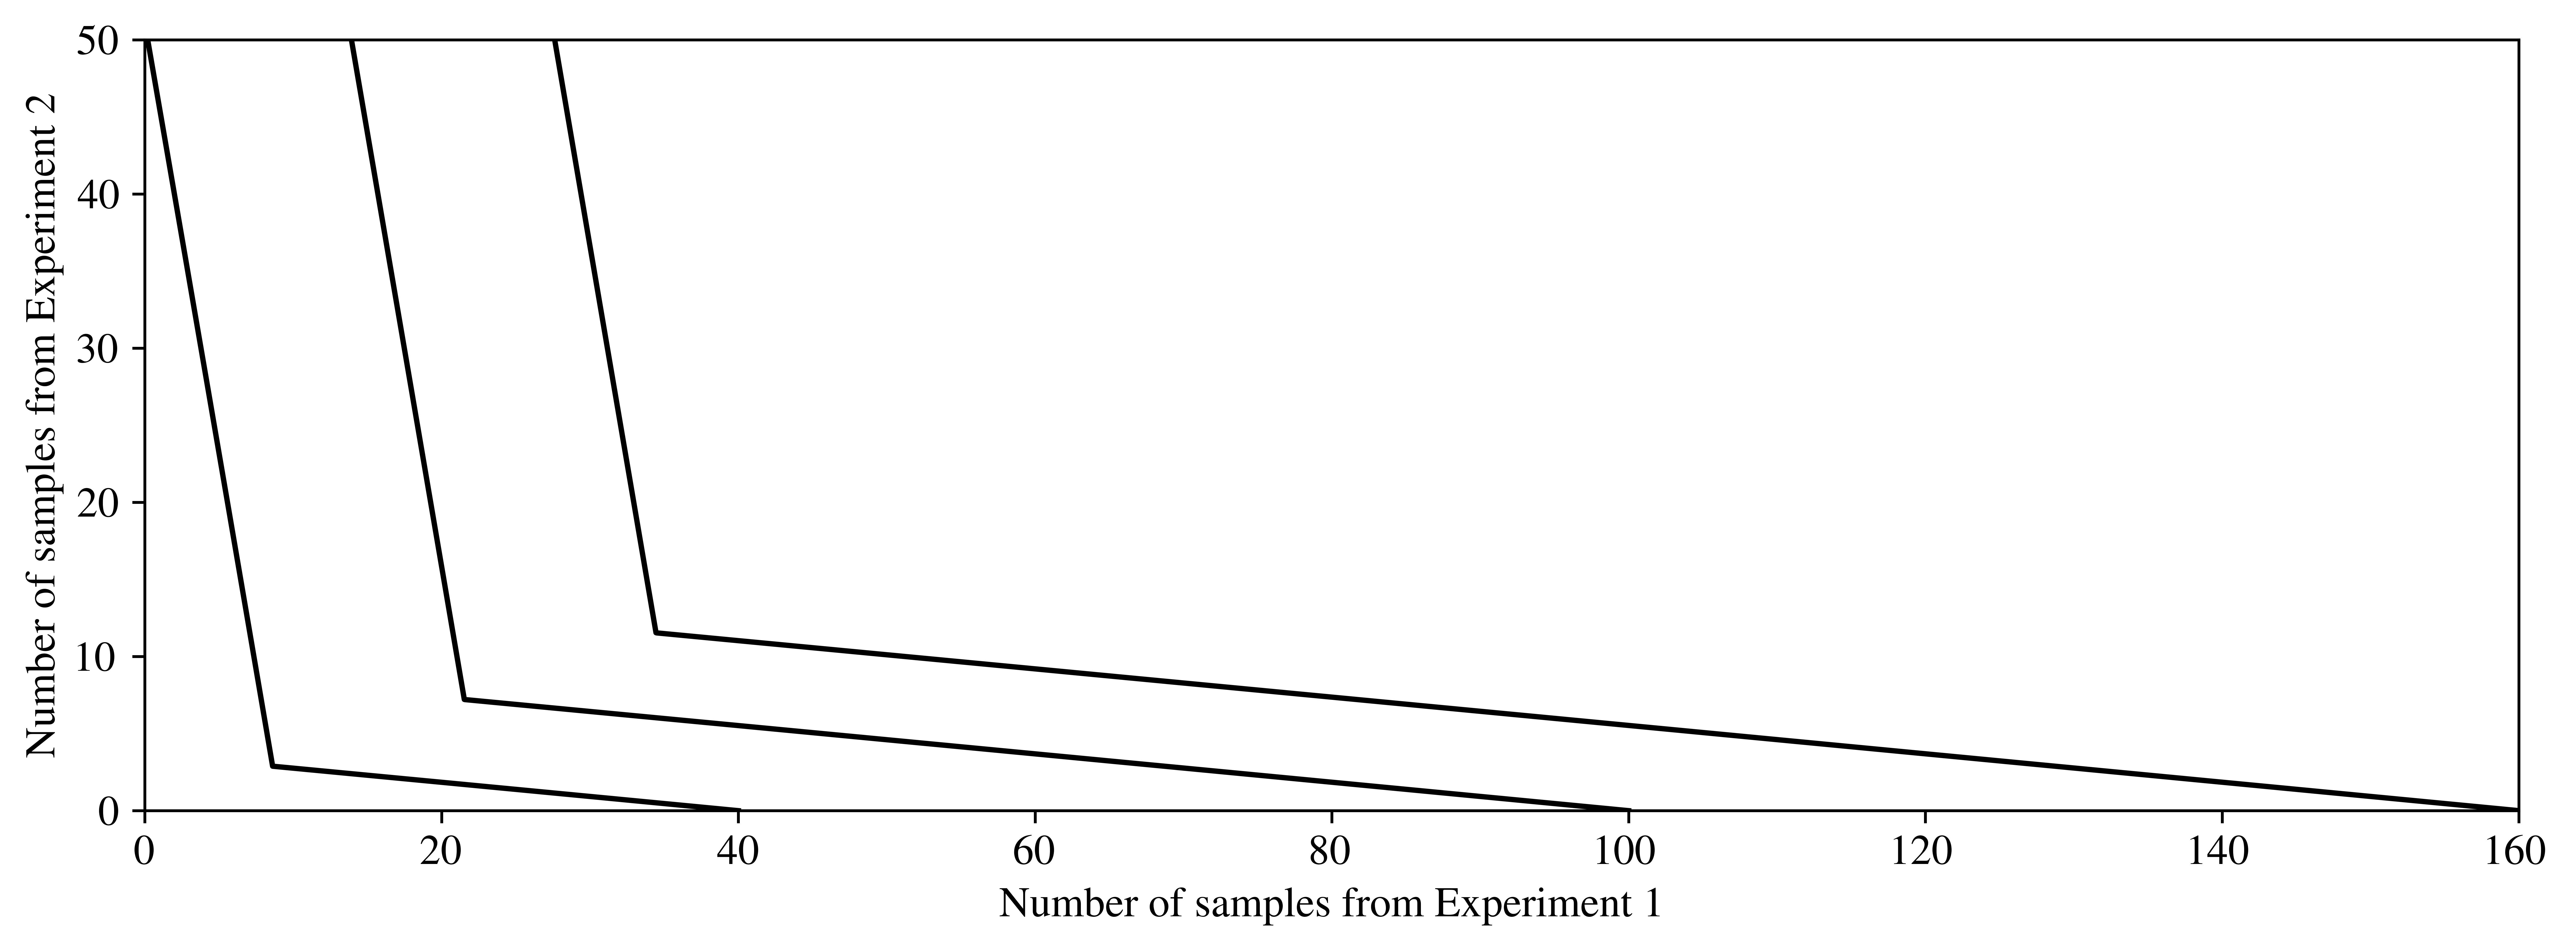

In [106]:
fig = plt.figure(figsize=(12, 4), dpi=1000)
ax = fig.add_subplot(1,1,1)
ax.set_xlim((0, 160))
ax.set_ylim((0, 50))
ax.set_xlabel('Number of samples from Experiment 1')
ax.set_ylabel('Number of samples from Experiment 2')
for i in range(len(n1pointsapprox)):
    ax.plot(n1pointsapprox[i], n2pointsapprox[i], 'k')

We similarly compute the iso-precision lines for a given precision level for a given dichotomy:

In [107]:
def iso_precision(precision, state1, state2, Q1, Q2):
    dr = 0.0005
    numstates = Q1.shape[0]
    # restrict both tests to the dichotomy of interest
    Q1d = Q1[[state1,state2],:]
    Q2d = Q2[[state1,state2],:]
    n1points, n2points = [], []
    for r in np.arange(0,1+dr,dr):
        N = precision / total_precision(Q1d, Q2d, r)
        n1points.append(r*N)
        n2points.append((1-r)*N)
    return n1points, n2points
    
numdichotomies = int((numstates * (numstates-1))/2)
# empty matrix for n2 points for each iso-precision line
isoprecn1points = []
isoprecn2points = []
dichotomyidx = 0     # index for dichotomy of current iteration
startprecision = n1starts[0]*total_precision(Q1, Q2, 1)
for state1 in range(numstates):
    for state2 in range(state1+1, numstates):
        n1points, n2points = iso_precision(startprecision, state1, state2, Q1, Q2)
        isoprecn1points.append(n1points)
        isoprecn2points.append(n2points)
        dichotomyidx += 1

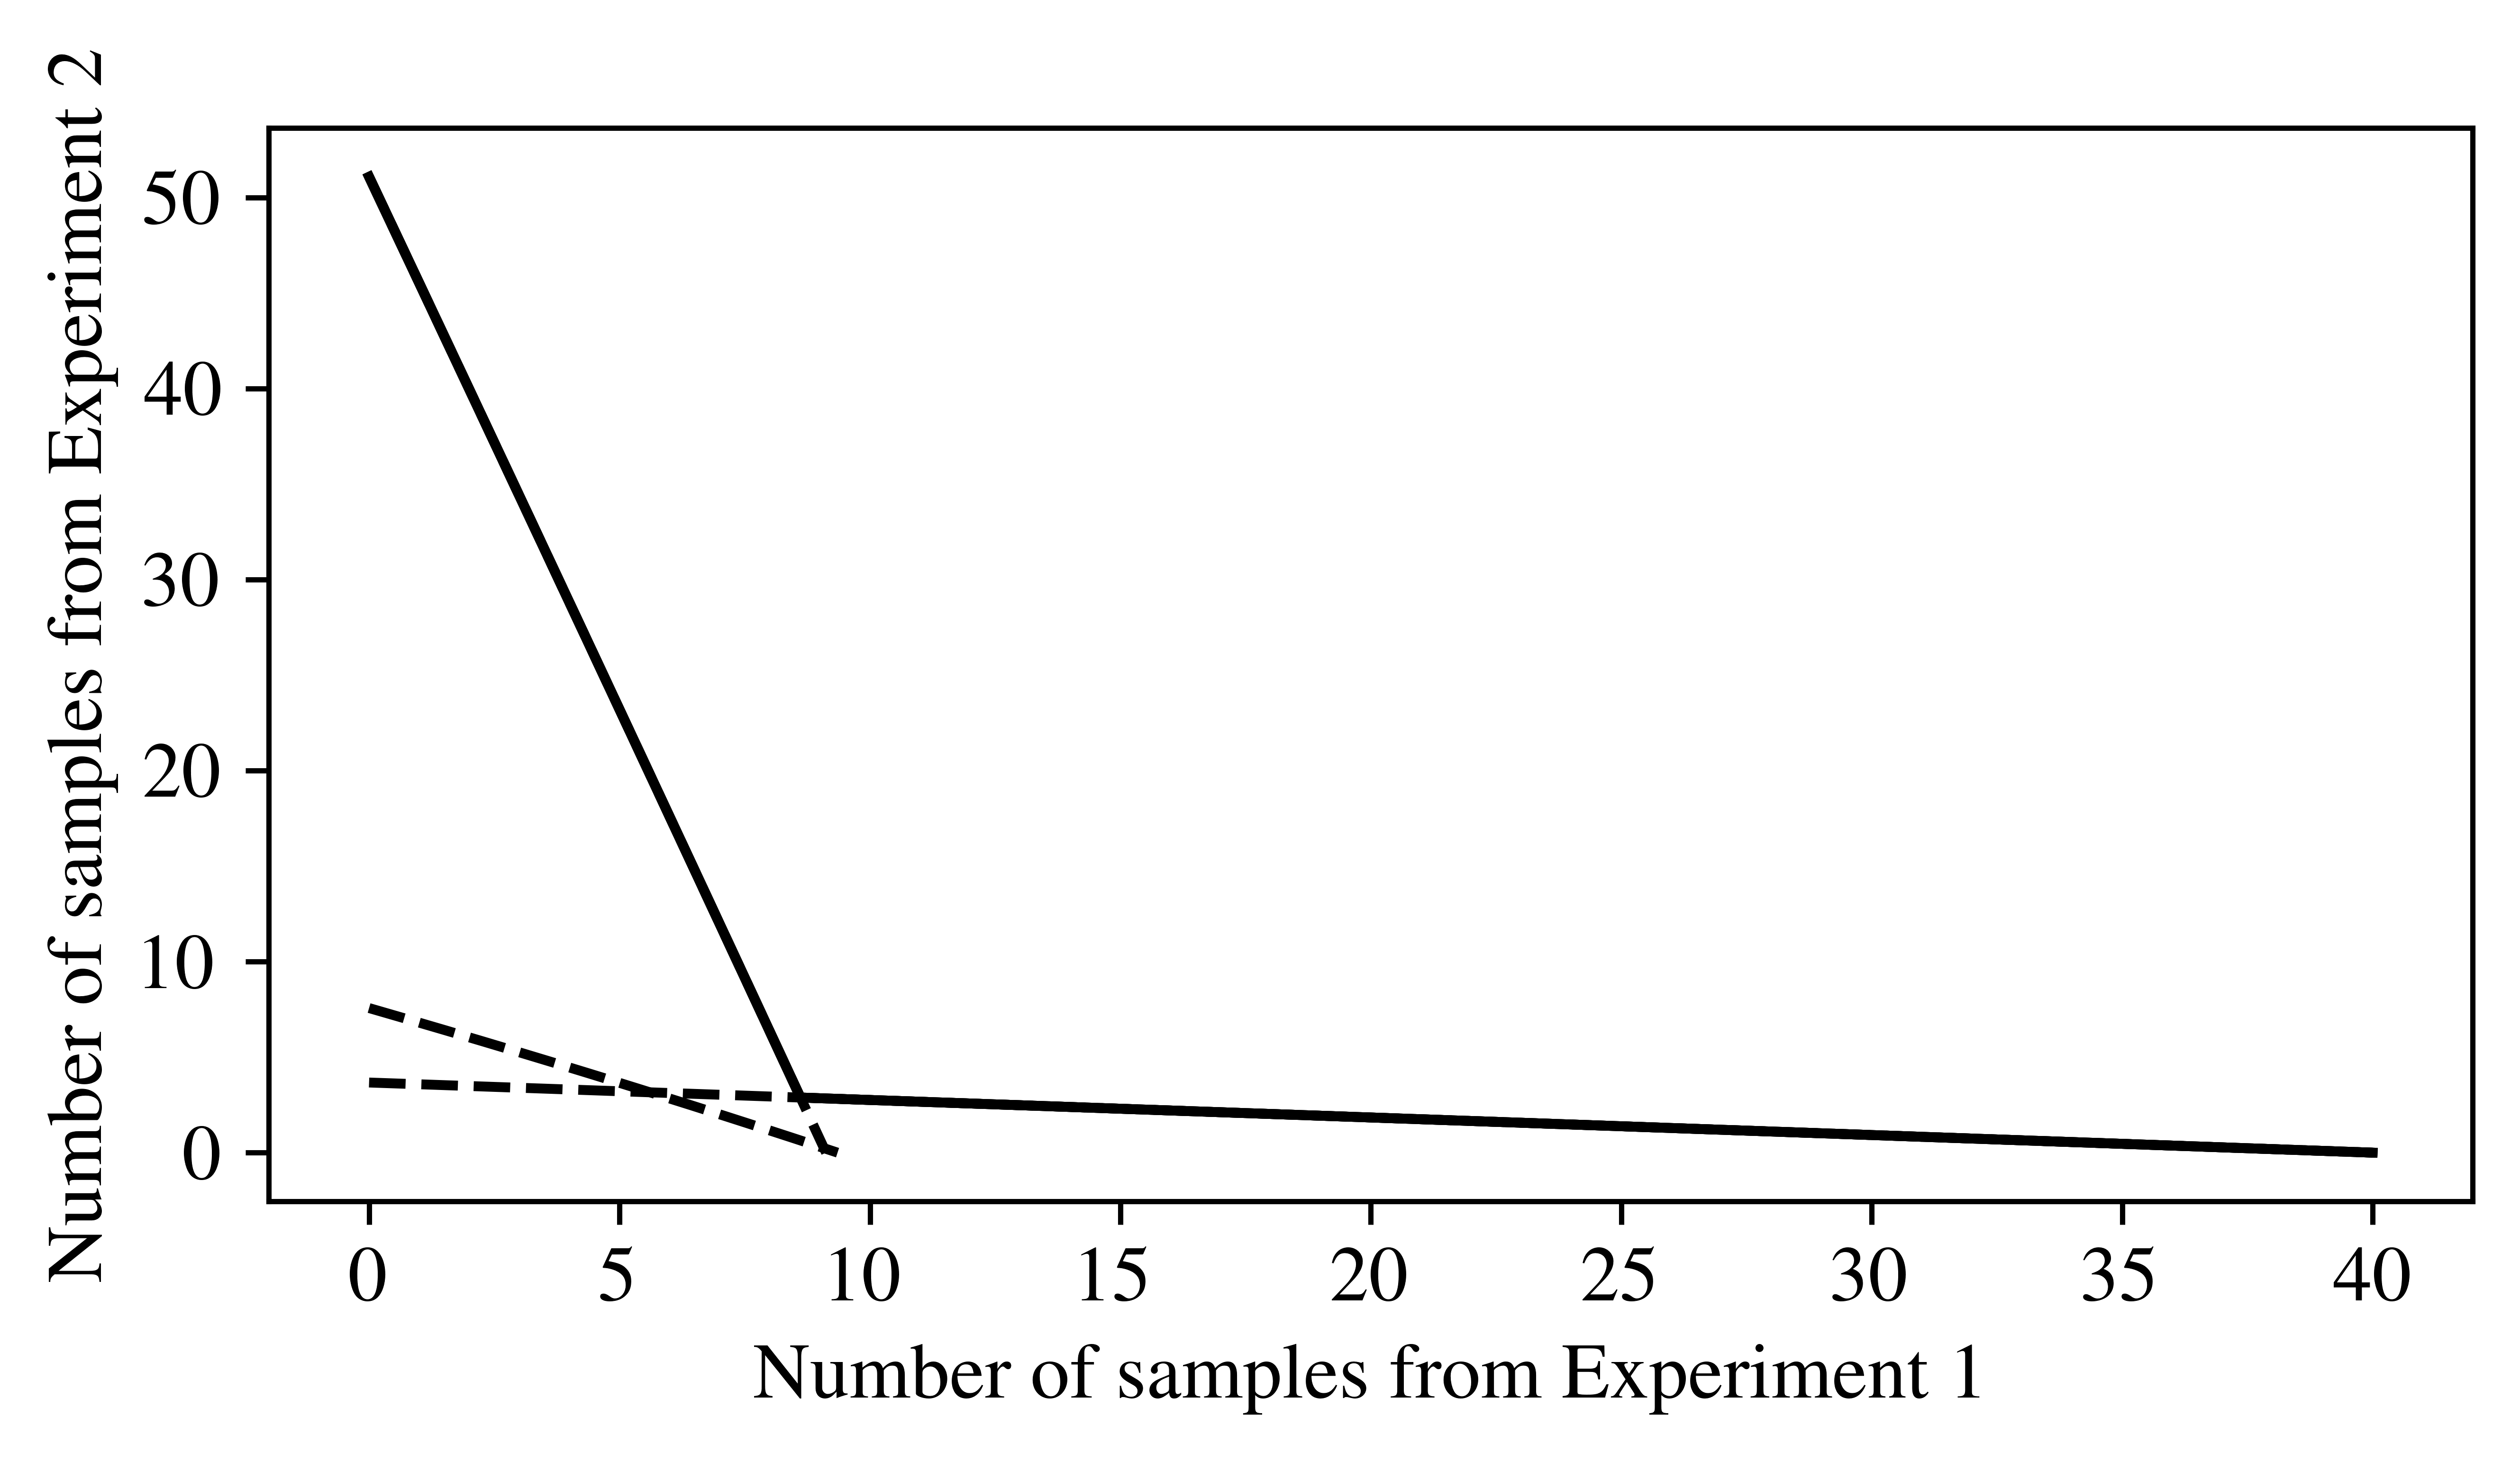

In [108]:
fig = plt.figure(figsize=(6,3), dpi=1000)
ax = fig.add_subplot(1,1,1)
#ax.set_xlim((0, 50))
#ax.set_ylim((0, 25))
ax.set_xlabel('Number of samples from Experiment 1')
ax.set_ylabel('Number of samples from Experiment 2')
for dichotomy in range(numdichotomies):
    ax.plot(isoprecn1points[dichotomy], isoprecn2points[dichotomy], '--k');
    ax.plot(n1pointsapprox[0], n2pointsapprox[0], 'k');

Samples are discrete so we can't compute exact indifference curves. Instead, we'll plot the locus of sample bundles that perform *just* better than some initial starting bundle (that is, the lower edge of the upper contour set). 

To find all such points, it will be useful to be able to first find the $\mathcal{E}_1$ corner bundle that does just better than some given bundle.

In [109]:
def just_better_corner(n1,n2):
    Q1n = n_samples(Q1, n1)
    Q2n = n_samples(Q2, n2)
    Qcomp = composite_source(Q1n, Q2n)
    startval = info_value(Qcomp, U, P)    # value of initial sample bundle
    # First find the n1 corner just better
    # We'll use this as our starting point
    n1running = n1
    currentval = 0
    # do a quick and dirty midpoint method
    # double sample size until something does better
    while currentval < startval:
        n1running = 2*n1running
        Q1n = n_samples(Q1, n1running)
        currentval = info_value(Q1n, U, P)
    n1upper = n1running
    n1lower = (1/2)*n1running
    # find number of times we can halve the distance
    numsplits = int(math.log(n1upper-n1lower, 2))
    # split 1 less than the max, so we should get very close
    for split in range(numsplits-1):
        n1mid = int((n1upper-n1lower)/2)
        Q1n = n_samples(Q1, n1mid)
        currentval = info_value(Q1n, U, P)
        if currentval > startval: 
            n1upper = n1mid
        else:
            n1lower = n1mid
    
    #reset currentval then count up from n1lower by 1
    currentval = 0
    # add 1 until something does just better
    n1running = n1lower
    while currentval < startval:
        n1running = n1running + 1
        Q1n = n_samples(Q1, n1running)
        currentval = info_value(Q1n, U, P)

    return n1running

Now we can trace out the lower edge of the upper contour set.

In [110]:
def inclusive_range(start, end, step):
    i = start
    while i < end:
        yield i
        i += step
    yield end
    
def ucs_true(n1, n2):
    #step = int((n1+n2)//20) + 1  # Use a coarse step for faster computation
    step = 1   # use a step size of 1 for exact, but slow, computation
    Q1n = n_samples(Q1, n1)
    Q2n = n_samples(Q2, n2)
    Qcomp = composite_source(Q1n, Q2n)
    startval = info_value(Qcomp, U, P)    # value of initial sample bundle
    # First find the n1 corner just better
    # We'll use this as our starting point
    if n2 > 0:
        n1start = just_better_corner(n1, n2)
    else: n1start = n1
    # Trace out the lower extent of the UCS
    n2 = 0      # start with no samples from Q2
    n1pointstrue = [n1start]
    n2pointstrue = [0]
    for n1loss in inclusive_range(1, n1start, step):
        n1 = n1start - n1loss
        n1pointstrue.append(n1)
        Q1n = n_samples(Q1, n1)
        # find minimum samples from Q2 to make better off
        currentval = 0
        while currentval < startval:
            n2 = n2 + 1
            Q2n = n_samples(Q2, n2)
            Qcomp = composite_source(Q1n, Q2n)
            currentval = info_value(Qcomp, U, P)
        n2pointstrue.append(n2)
        n2 = n2 - 1     # decr. n2 just to be sure later
    return n1pointstrue, n2pointstrue

In [111]:
n1pointstrue, n2pointstrue = [], []
for n1 in n1starts:
    n1points, n2points = ucs_true(n1, 0)
    n1pointstrue.append(n1points)
    n2pointstrue.append(n2points)

And then plot the true upper contour set boundary against the iso-least-precision lines.

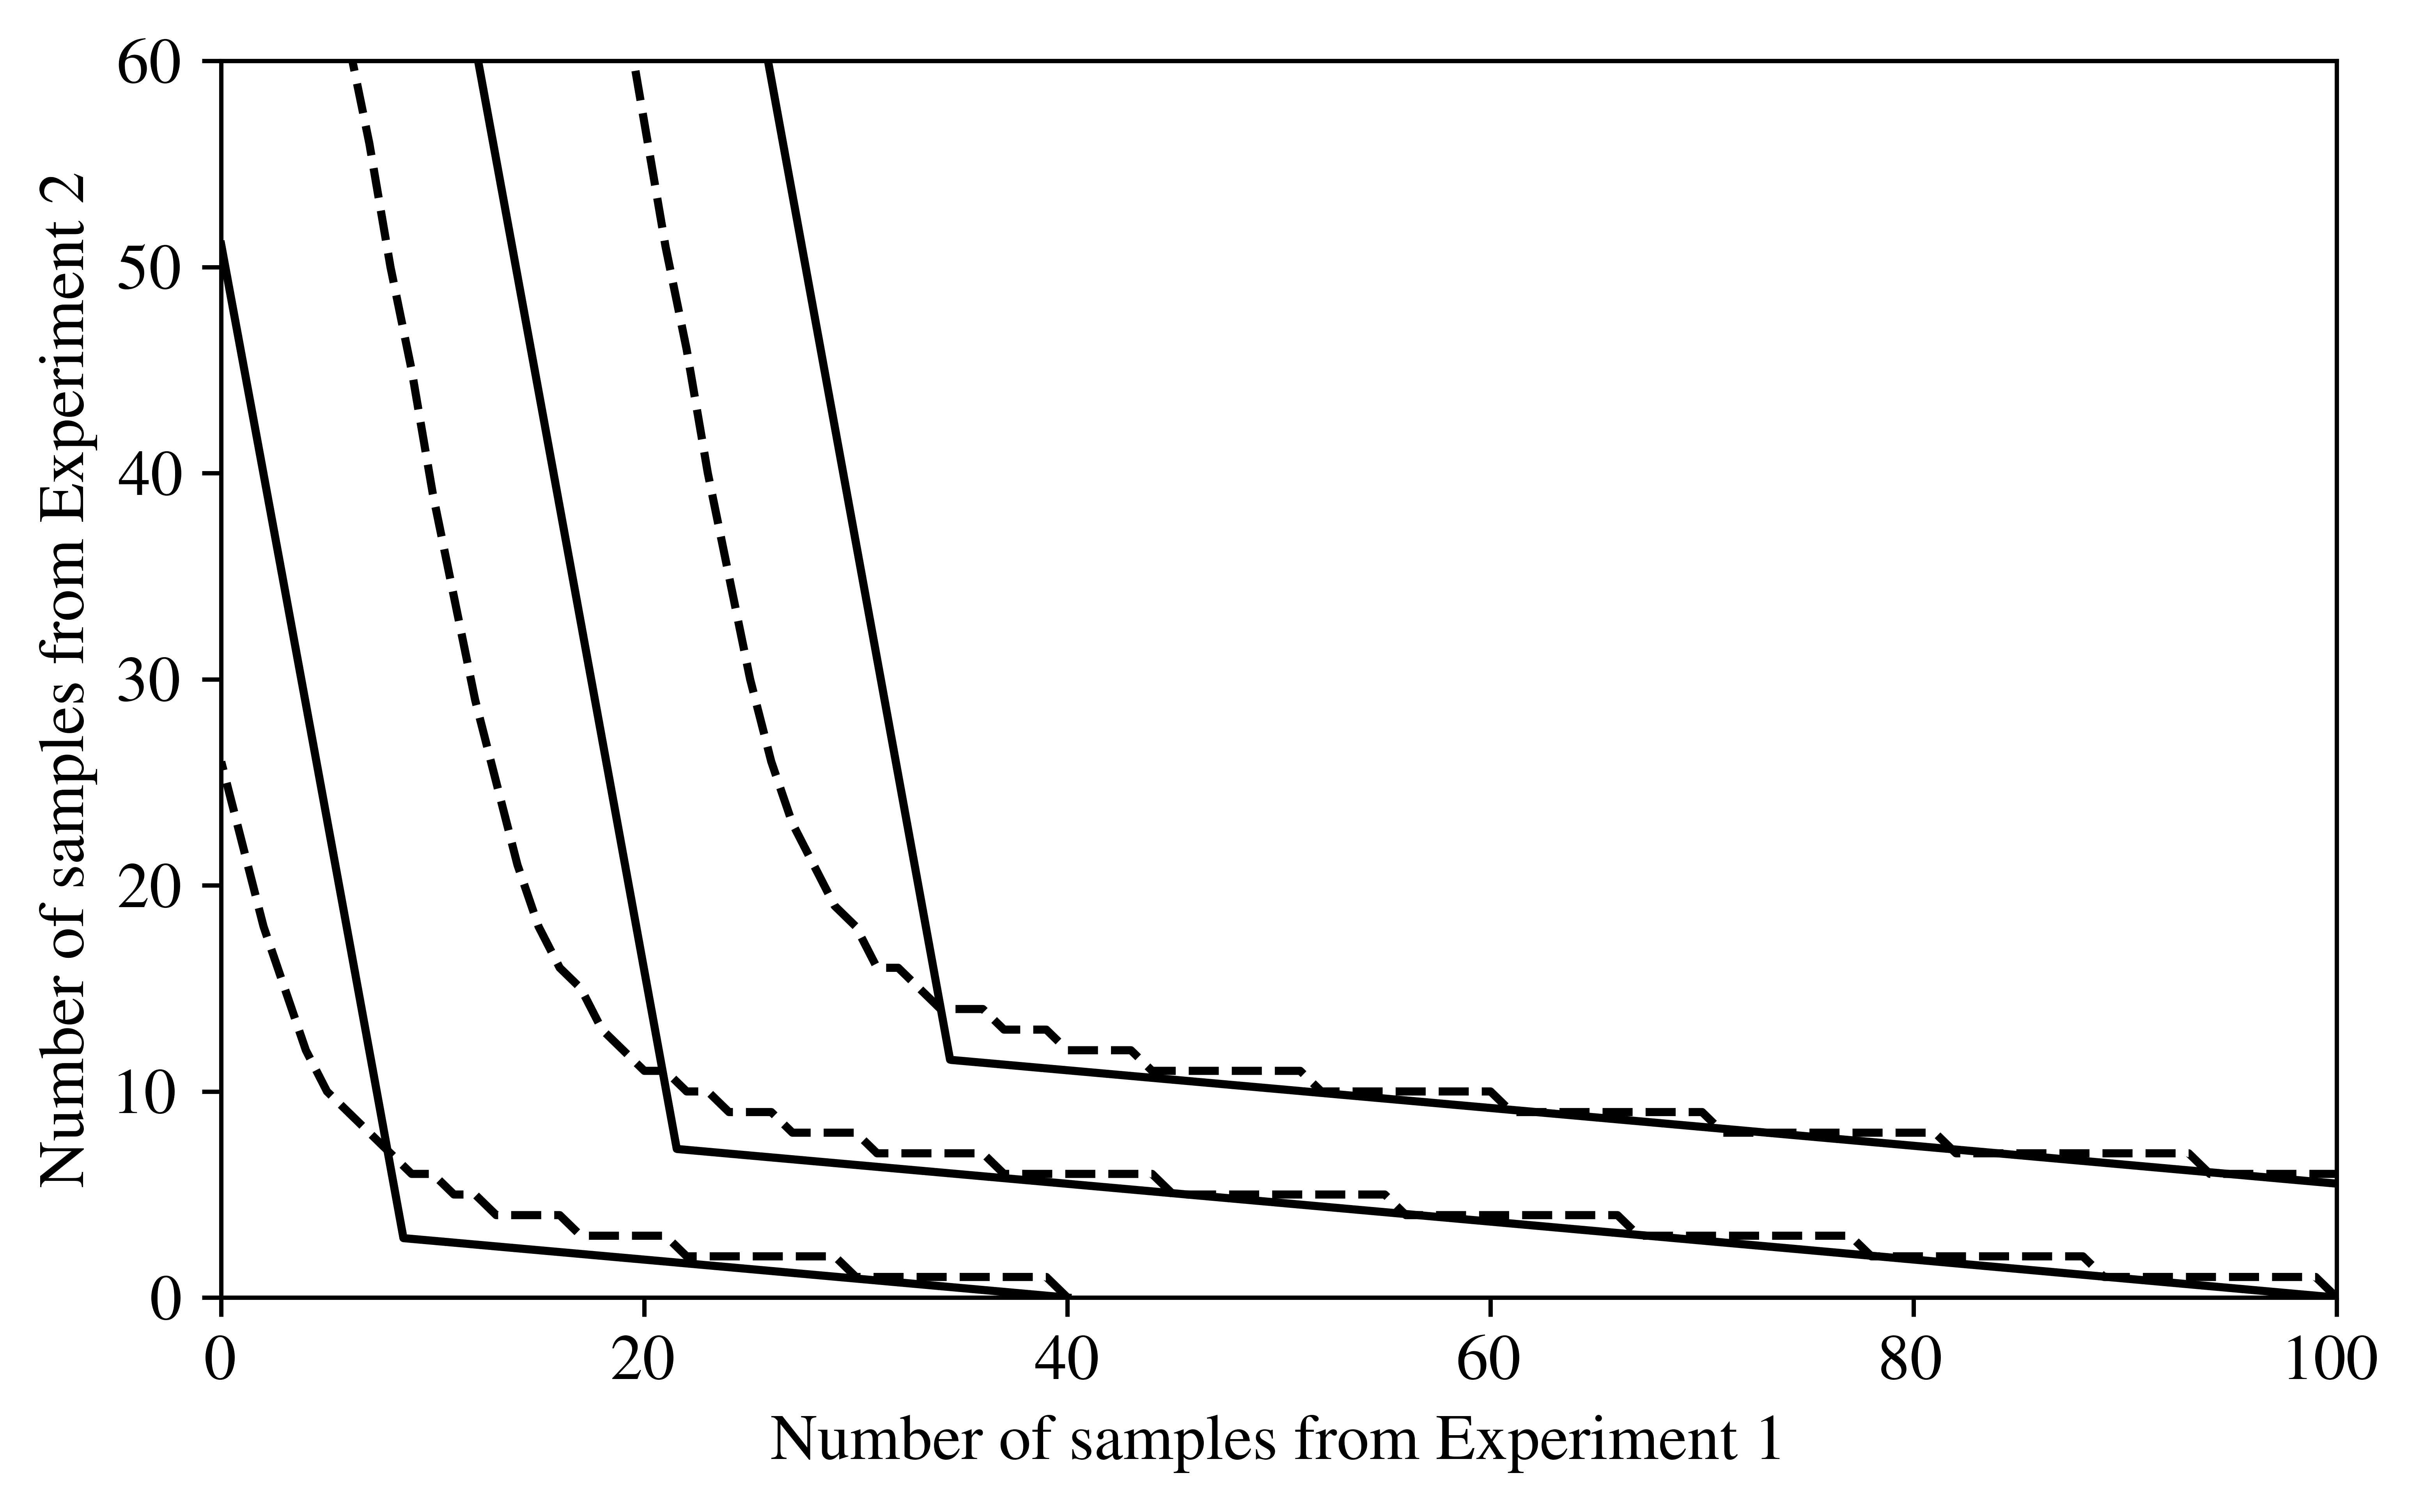

In [112]:
fig = plt.figure(figsize=(7,4.2), dpi=1000)
# set matching font
fontProperties = {'family':'serif','serif':['Times'],
    'weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
ax = fig.add_subplot(1,1,1)
ax.set_xlim((0, 100))
ax.set_ylim((0, 60))
ax.set_xlabel('Number of samples from Experiment 1')
ax.set_ylabel('Number of samples from Experiment 2')
for i in range(len(n1pointstrue)):
    ax.plot(n1pointstrue[i], n2pointstrue[i], '--k',
            n1pointsapprox[i], n2pointsapprox[i], 'k');
#plt.savefig('figdiscrete.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0)

# Income expansion paths

Now we want to plot some income expansion paths. First, we'll compute the true demand for a variety of income levels, then plot the UC sets for those demand points, against their iso-precision lines.

In order to reduce the computational complexity of finding demand, we can restrict the search to a region around the maxi-min precision proportions. First, we find all kinks/corners by finding points where the slope of the iso-precision line falls in magnitude.

In [24]:
# compute mrs by composite factor, find kinks
mrs = []
dr = 0.01
rgrid = np.arange(0, 1, dr)
kinks = [0, 1]
for r in rgrid:
    beta1r, beta2r = comp_precision(Q1, Q2, r)
    mrs.append(beta1r / beta2r)
    if r > dr and mrs[-1] < mrs[-2] - 0.001:    # mrs only falls at kink points
        kinks.append(r)

print(tabulate([["Kinks at composite factors:"] + kinks]))

---------------------------  -  -  ----
Kinks at composite factors:  0  1  0.75
---------------------------  -  -  ----


Given a selection of sample proportions (the kinks and corners), for a given set of prices, we can find the one with best least precision per dollar. We can then search for the optimal sample bundle in the region around this point. Provided the search region is large enough, we will find the true optimal bundle.

In [25]:
def demand(Y, c1, c2, kinks, epsilon):
    # first find maxi-min precision per dollar
    ppd0 = 0
    for r in kinks: 
        ppd1 = total_precision(Q1, Q2, r) / (r*c1 + (1-r)*c2)
        if ppd1 > ppd0:
            ppd0 = ppd1
            rstar = r
    # maxi-min precision bundle under budget Y is
    N = Y / (rstar*c1 + (1-rstar)*c2)
    n1star, n2star = rstar*N, (1-rstar)*N
    # Candidate bundles are the feasible bundles with n1 within epsilon
    # of the maxi-min precision bundle (n1star, n2star) and are affordable
    value = 0
    n1Lbar = max(0,int(n1star-epsilon))            # lowest n1 can't be negative
    n1Ubar = min(int(n1star+epsilon), int(Y/c1))   # biggest n1 must be affordable
    for n1 in range(n1Lbar, n1Ubar+1):
        n2 = int((Y - (c1*n1)) / c2)   # highest affordable n2
        # compute value bundle
        Q1n = n_samples(Q1, n1)
        Q2n = n_samples(Q2, n2)
        Qcomp = composite_source(Q1n, Q2n)
        checkvalue = info_value(Qcomp, U, P)
        # check if value is higher than previous best and store if so
        if checkvalue > value:    
            value = checkvalue
            n1best, n2best = n1, n2
    if n1best == n1Lbar:
        print('corner warning L')
    elif n1best == n1Ubar:
        print('corner warning U')
    
    return n1best, n2best

For default example, based on the previous plots of the UCS boundary vs the iso-least-precision curves, it seems that for price ratios not too close to the cutoffs between kinks and corners, the optimal bundle should always have $n_1$ well within about 30 samples. So we'll use that as our search range. Setting $\epsilon$ to some large number will guarantee that the true demand is found, but at high computational costs. (Higher budgets might takes days)

In [26]:
epsilon = 100

# prices
c1, c2 = 2, 1
budgets = [5, 20, 40, 60, 80, 100, 150, 200, 300, 400]
#budgets = [10,20,30]
# Also compute the maxi-min precision ratio
ppds = [total_precision(Q1, Q2, r) / (r*c1 + (1-r)*c2) for r in kinks]
rstar = kinks[ppds.index(max(ppds))]

In [ ]:
n1demand, n2demand = [], []
for Y in budgets:
    n1, n2 = demand(Y, c1, c2, kinks, epsilon)
    n1demand.append(n1)
    n2demand.append(n2)

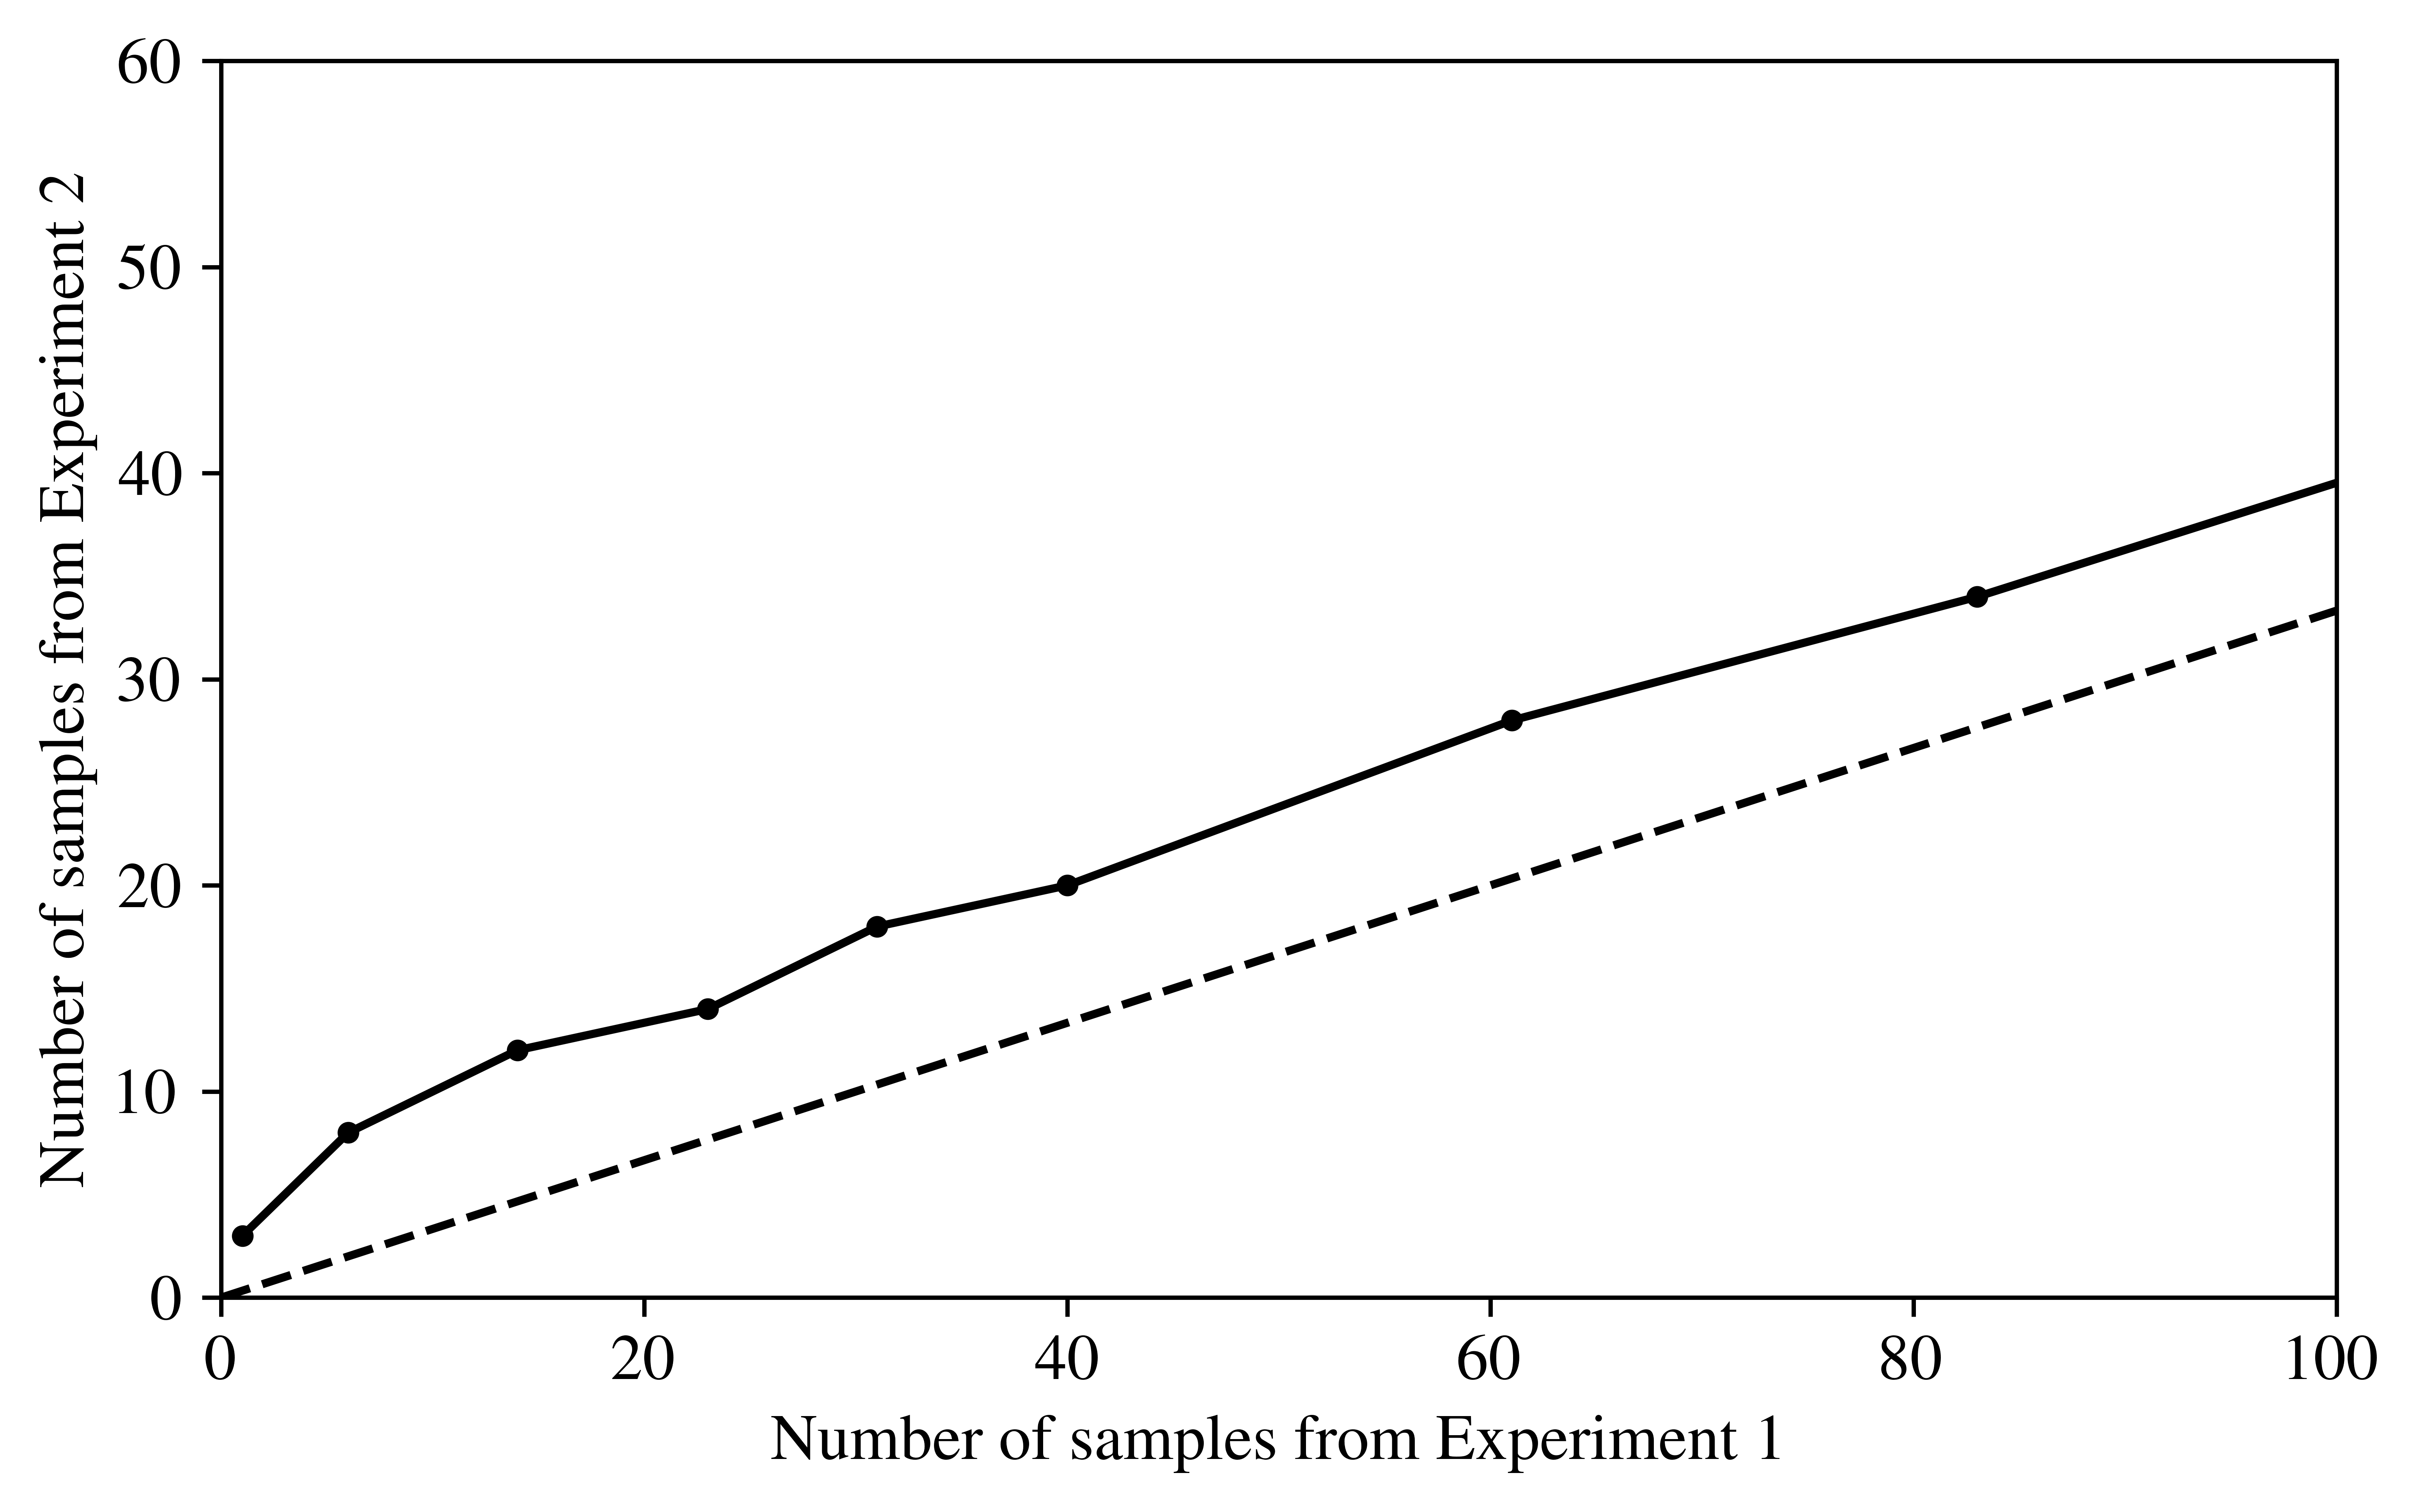

In [33]:
fig = plt.figure(figsize=(7,4.2), dpi=1000)
# set matching font
fontProperties = {'family':'serif','serif':['Times'],
    'weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
ax = fig.add_subplot(1,1,1)
ax.set_xlim((0, 100))
ax.set_ylim((0, 60))
ax.set_xlabel('Number of samples from Experiment 1')
ax.set_ylabel('Number of samples from Experiment 2')
ax.plot(n1demand, n2demand, '.-k');

n1rstar = np.arange(0,100,0.01)
rstarRay = n1rstar*(1-rstar)/rstar
ax.plot(n1rstar, rstarRay, '--k');

Now compute upper contour sets for some of the points on the income expansion path.

In [ ]:
n1ucs, n2ucs = [], []
for i in [2, 5, 6]:
    n1points, n2points = ucs_true(n1demand[i],n2demand[i])
    n1ucs.append(n1points)
    n2ucs.append(n2points)

Now we want some iso-precision lines to go with the upper contour sets. We'll get a nicer looking plot if we compute the iso-precision lines through one of the corner bundles on upper contour set boundary.

In [ ]:
n1corners = []
for i in range(len(n1ucs)):
    # first entry in uCS plot is the n1 corner
    n1corners.append(n1ucs[i][0])
    
# compute the iso-precision lines
n1isoprec, n2isoprec = [], []
for n1 in n1corners:
    #n1points, n2points = mrs_approx(n1start)
    n1points, n2points = iso_least_precision(n1, 0, Q1, Q2)
    n1isoprec.append(n1points)
    n2isoprec.append(n2points)

The above code can take a *very* long time to compute. The following code will save/load the results for use later.

In [ ]:
import pickle
#with open('savedvars.pkl','wb') as f:
#    pickle.dump([n1demand,n2demand,n1ucs,n2ucs,n1isoprec,n2isoprec], f)

In [ ]:
with open('savedvars.pkl','rb') as f:
    n1demand,n2demand,n1ucs,n2ucs,n1isoprec,n2isoprec = pickle.load(f)

Finally, plot everything.

In [ ]:
fig = plt.figure(figsize=(7,4), dpi=1000)
# set matching font
fontProperties = {'family':'serif','serif':['Times'],
    'weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
ax = fig.add_subplot(1,1,1)
ax.set_xlim((0, 100))
ax.set_ylim((0, 60))
ax.set_xlabel('Number of samples from Experiment 1')
ax.set_ylabel('Number of samples from Experiment 2')
for i in range(len(n1ucs)):
    ax.plot(n1ucs[i], n2ucs[i], '--k',
            n1isoprec[i], n2isoprec[i], 'k');
ax.plot(n1demand, n2demand, '.-k');

# plot ray of maxi-min precision ratio
n1rstar = np.arange(0,100,0.01)
rstarRay = n1rstar*(1-rstar)/rstar
ax.plot(n1rstar, rstarRay, '--k');

rstarlower = rstarRay - 5
rstarupper = rstarRay + 11
ax.plot(n1rstar, rstarlower, ':k', linewidth=1.5);
ax.plot(n1rstar, rstarupper, ':k', linewidth=1.5);

plt.savefig('figincomeexpansiondiscrete.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0, transparent=True)